In [1]:
import cv2                 
import numpy as np         
import os                  
from random import shuffle
import tensorflow as tf 
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob as gb
from tensorflow.keras.utils import to_categorical

In [2]:
from keras.layers import Dense, Flatten, AveragePooling2D, Dropout
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
%matplotlib inline

from skimage.segmentation import mark_boundaries
import lime
from lime import lime_image


In [3]:
#read dataset
TrianImage="Data/train/"
TestImage="Data/test/"


print(TrianImage)
print(TestImage)

Data/train/
Data/test/


In [4]:
#to get all image names in train file
Pneumonaimages = os.listdir(TrianImage + "/PNEUMONIA")
Normalimages = os.listdir(TrianImage + "/NORMAL")
COVID19images = os.listdir(TrianImage + "/COVID19")

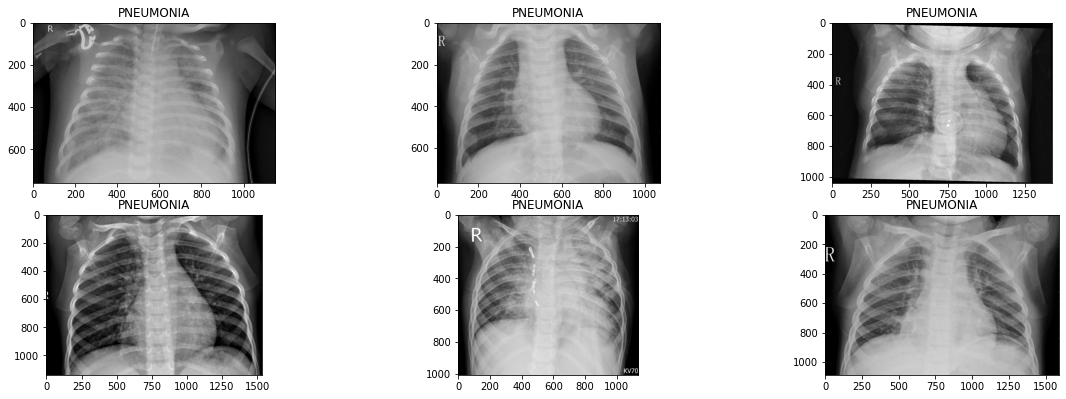

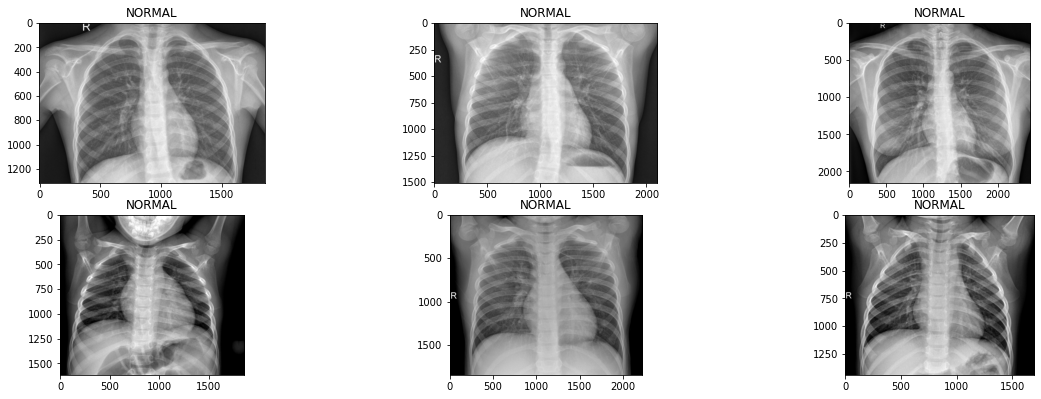

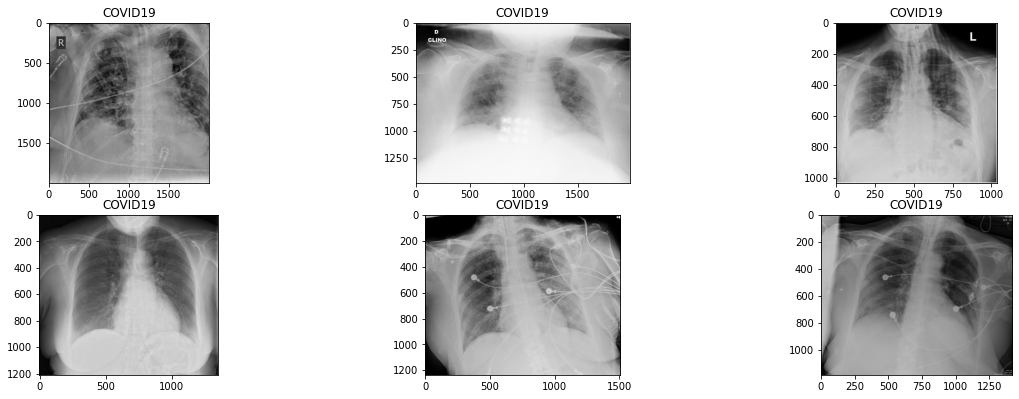

In [5]:
#Explore the Data
#plot PNEUMONIA
plt.figure(figsize=(20,10))
for i in range(6):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(TrianImage + "/PNEUMONIA",Pneumonaimages[i])),cmap='gray')
    plt.title("PNEUMONIA")
    
plt.show()
#plot NORMAL
plt.figure(figsize=(20,10))
for i in range(6):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(TrianImage + "/NORMAL",Normalimages[i])),cmap='gray')
    plt.title("NORMAL")

plt.show()
#plot 
plt.figure(figsize=(20,10))
for i in range(6):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(TrianImage + "/COVID19",COVID19images[i])),cmap='gray')
    plt.title("COVID19")

In [6]:
data_path = "Data"

In [7]:
#build model
baseModel = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)

for layer in baseModel.layers:
  layer.trainable = False

headModel = baseModel.output
headModel = AveragePooling2D()(headModel) #further feature extraction
headModel = Flatten()(headModel)
headModel = Dense(128, activation="relu")(headModel) #fully connected layer with 128 units (nurons), relu for incrase non linearity
headModel = Dropout(0.2)(headModel) # 20% of droupout layer to avoid overfit, can make nurons untrainable
headModel = Dense(3, activation='softmax')(headModel)#output layer

model = Model(inputs=baseModel.input, outputs=headModel)

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [9]:
#parameter tuning
from keras.optimizers import Adam
opt=Adam(learning_rate=0.0001) # adam to perform Stochastic Gradient Descent
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

In [10]:
#image processing methods
def imgPro(img):    
    blured_img = cv2.medianBlur(img,(5,5)) # median filter with 5 x 5 kernal size
    img_adapteq = exposure.equalize_adapthist(blured_img, clip_limit=0.03) # histogram equalization
    return img_adapteq

#image augmentation
train_datagen = ImageDataGenerator(rescale = 1./255, #normalization (feature scaling)
                                   zoom_range = 0.2, # Range for random zoom
                                   rotation_range=15, # Range for random rotational shifts
                                   horizontal_flip = True # Range for random horizontal shifts
                                   preprocessing_function=imgPro)


test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(data_path + '/train',
                                                 target_size = (224, 224), #size of the input image
                                                 batch_size = 16, # accourding to computation power
                                                 class_mode = 'categorical',
                                                 shuffle=True)

test_set = test_datagen.flow_from_directory(data_path + '/test',
                                            target_size = (224, 224),
                                            batch_size = 16,
                                            class_mode = 'categorical',
                                            shuffle = False)

Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


In [11]:
# Fits the model on batches with real-time data augmentation
history = model.fit_generator(training_set,
                              validation_data=test_set,
                              epochs=30)  

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
322/322 [==============================] - 1238s 4s/step - loss: 0.4456 - accuracy: 0.8313 - val_loss: 0.2836 - val_accuracy: 0.8859
Epoch 2/30
322/322 [==============================] - 1165s 4s/step - loss: 0.2511 - accuracy: 0.9127 - val_loss: 0.2292 - val_accuracy: 0.9061
Epoch 3/30
322/322 [==============================] - 1364s 4s/step - loss: 0.2054 - accuracy: 0.9310 - val_loss: 0.2297 - val_accuracy: 0.9045
Epoch 4/30
322/322 [==============================] - 1475s 5s/step - loss: 0.1977 - accuracy: 0.9304 - val_loss: 0.1907 - val_accuracy: 0.9200
Epoch 5/30
322/322 [==============================] - 1170s 4s/step - loss: 0.1826 - accuracy: 0.9345 - val_loss: 0.2052 - val_accuracy: 0.9099
Epoch 6/30
322/322 [==============================] - 1169s 4s/step - loss: 0.1585 - accuracy: 0.9469 - val_loss: 0.1966 - val_accuracy: 0.9154
Epoch 7/30
322/322 [==============================] - 1169s 

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(len(acc))

Text(0.5, 1.0, 'Training and Validation Accuracy')

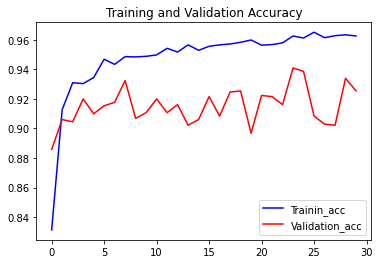

In [13]:
plt.plot(epochs,acc,label='Trainin_acc',color='blue')
plt.plot(epochs,val_acc,label='Validation_acc',color='red')
plt.legend()
plt.title("Training and Validation Accuracy")

Text(0.5, 1.0, 'Training and Validation loss')

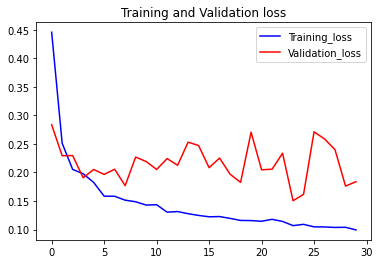

In [14]:
plt.plot(epochs,loss,label='Training_loss',color='blue')
plt.plot(epochs,val_loss,label='Validation_loss',color='red')
plt.legend()
plt.title("Training and Validation loss")

In [15]:
class_dict = {0:'COVID19',
              1:'NORMAL',
              2:'PNEUMONIA'}

prediction:  COVID19


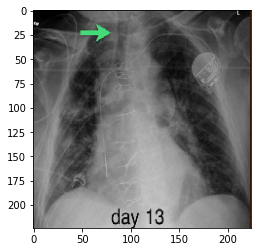

In [25]:
file_path =  '/test/COVID19/COVID19(503).jpg'
test_image = cv2.imread(data_path + file_path)
test_image = cv2.resize(test_image, (224,224),interpolation=cv2.INTER_NEAREST)
plt.imshow(test_image)
test_image = np.expand_dims(test_image,axis=0)
probs = model.predict(test_image)
pred_class = np.argmax(probs)

pred_class = class_dict[pred_class]

print('prediction: ',pred_class)

In [20]:
model.save('covid_model.h5') #save the model

prediction:  NORMAL


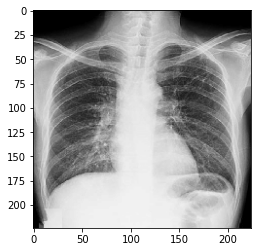

In [24]:
file_path =  '/11000.png'
test_image = cv2.imread(data_path + file_path)
test_image = cv2.resize(test_image, (224,224),interpolation=cv2.INTER_NEAREST)
plt.imshow(test_image)
test_image = np.expand_dims(test_image,axis=0)
probs = model.predict(test_image)
pred_class = np.argmax(probs)

pred_class = class_dict[pred_class]

print('prediction: ',pred_class)